# Access a PLANQK service 

This tutorial demonstrates how to access an existing PLANQK service using the PLANQK Service SDK.



Make sure you installed the latest version of the PLANQK Service SDK.

In [16]:
import sys

!{sys.executable} -m pip install --upgrade planqk-service-sdk

Defaulting to user installation because normal site-packages is not writeable


Create an instance of the `PlanqkServiceClient`. Provide the endpoint of the service you want to access together with the `consumer_key`and `consumer_secret`of the your application that is subscribed to the service.

In [17]:
from planqk.service.client import PlanqkServiceClient

consumer_key = "9wdVkrsZdNudSntSBBXbLDjToroa"
consumer_secret = "8_h8UuACSSj6rj644nEe0x3WpqAa"
service_endpoint = "https://gateway.platform.planqk.de/kipu-quantum/planqk-tutorial---fleet-route-planning/1.0.0"

client = PlanqkServiceClient(service_endpoint, consumer_key, consumer_secret)


Prepare the input data and parameters to be sent to the service. 

In [18]:

weight_dict = {
    "(0, 1)": 0.11,
    "(0, 2)": 0.44,
    "(0, 3)": 0.27,
    "(0, 4)": 0.13,
    "(1, 2)": 0.62,
    "(1, 3)": 0.2,
    "(2, 4)": 0.41,
    "(3, 4)": 0.71,
}

number_couriers = 2

data = {"weight_dict": weight_dict}

params = {
        "solver": "sim_anneal",
        "n_clusters": number_couriers,
        "num_sweeps_sa": 300,
        "num_reads_sa": 10000,
        "num_reads_qa": 1000,
        "annealing_time": 20,
    }


Start a service execution by passing the prepared input arguments and retrieve the result.

In [19]:
job = client.start_execution(data=data, params=params)
job_result = client.get_result(job.id)
routes_list = job_result["result"]["routes_list"]


After receiving the result, you can process it further as needed. For example, you can visualize the result as a plot or save it to a file.

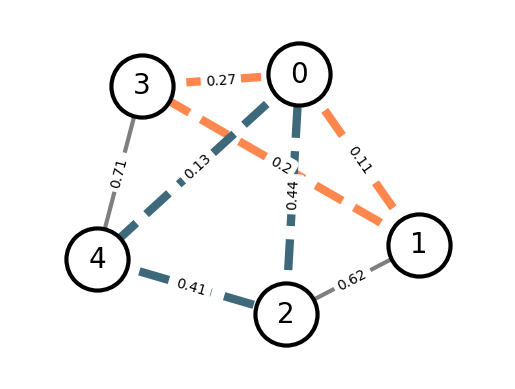

In [20]:
import random
import matplotlib.pyplot as plt
import networkx as nx

G = nx.empty_graph()

for key in weight_dict:
    # Remove parentheses and split the string by ','
    node_pair = key.strip('()').split(', ')
    # Convert the pair to integers
    node1, node2 = int(node_pair[0]), int(node_pair[1])
    G.add_edge(node1, node2, weight=weight_dict[key])
    


pos = nx.spring_layout(G, seed=42)

# draw nodes
nx.draw_networkx_nodes(
    G, pos, node_size=2000, node_color="white", edgecolors="black", linewidths=3
)
# draw node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

courier_routes = {}
all_edges = [(u, v) for (u, v, d) in G.edges(data=True)]

for route in routes_list:
    route_edges = [eval(item) for item in route["naive_route_edges"]]
    courier_routes[route["cluster_id"]] = []
    for u, v in route_edges:
        if (u, v) in all_edges or (v, u) in all_edges:
            courier_routes[route["cluster_id"]].append((u, v))
            # remove (u, v) from all_edges
            all_edges.remove((u, v)) if (u, v) in all_edges else None
            all_edges.remove((v, u)) if (v, u) in all_edges else None

# draw courier routes
for route in courier_routes.values():
    # random color
    color = "#" + "".join([random.choice("0123456789ABCDEF") for j in range(6)])
    nx.draw_networkx_edges(
        G, pos, edgelist=route, width=6, style="dashed", edge_color=color
    )

# draw remaining edges
nx.draw_networkx_edges(G, pos, edgelist=all_edges, width=3, alpha=0.5)

# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()